In [2]:
import torch
from torch.utils import data
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import cv2

import csv

from progressbar import *               # just a simple progress bar

In [3]:
import my_classes # With that way we import the my_classes code inside and we 
# have the ability to run my_classes.customDatasetVideos in the next block

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set up the GPU
print(device)

cuda:0


## Creating the model of the Neural network

The size of the new layer $$H_{new} = \frac{H_{old}+2*Padding_H-Kernel_H}{Stride_H}+1$$ 

most of the time is just $H_{new} = H_{old}-Kernel_H+1$ becuase we don't have Padding and stride

Lets $H=150$ this means that $H_{new} = 150-5+1$ and all that needs to be devided by two becasue we have padding so $H_{new}=146/2=73$

The same will happen in the next step so $H_{2 New} = 34$

And now we need to find the size that this feature volume will be transformed in order to do the Fully connected layer part, the size will be $34*34*channels = 23120$

In [4]:
class Net(nn.Module):
    
    def __init__(self): # Initialize the parameters of the model 
        
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(3,10,kernel_size=5) # from 3 channels wich is RGB to 10 channels
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv3 = nn.Conv2d(20,20,kernel_size=5)
        
        self.mp = nn.MaxPool2d(2) # This means that the size of the window will me 2 so the whole image will be devidd by 2
        
        self.fc1 = nn.Linear(4500,5000)
        self.fc2 = nn.Linear(5000,500)
        self.fc3 = nn.Linear(500,46) # need to 45 because the classes are 45
        
        
    def forward(self,x):
        
        in_size = x.size(0)
        
        # print(x.shape)
        
        x=self.conv1(x)
        x=self.mp(x)
        x=F.relu(x)
        
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))
        print(x.shape)
        
        x = x.view(in_size, -1)  # flatten the tensor
        print(x.shape)
        
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        
        return F.log_softmax(x)
        
        
model = Net()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

## Data Loader - Train Model

In [5]:
# for now we only need the path of the csv that have inside the labels and the paths of the videos 
custom_mnist_from_csv = my_classes.customDatasetVideos('videoPath_labels.csv',frameStart=5,frames=5,startH=30,startW=30,heightVid=150,widthVid=150)


# This is the data loader which is created automatically by pytorch in order to 
# take batches of the videos until you read all the videos 
mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=50, shuffle=True, num_workers = 15)
# num_workers -> tell us how many data loaders will happen at the same time in the CPU in you make this number high enought 
# you will basically stop having bottleneck in the data collection and the bottle neck will be in the actual neural network


ArrI=[]
ArrLoss=[]
i=0

for epoch in range(10): # An epoch is basically when we finish the wholde data set and we want to train again from the start 
    
    model.train()
    for vid, labels in mn_dataset_loader: # This makes many itterations until finishes the whole data set which is really long about 6000 videos this menas the the whole system is really slow and we need to chagne something in the future 
        
        # vid, labels = vid.to(device), labels.to(device) # With this way we transfer all the arrays to the GPU in order to make the processes there 
          
        i=i+1
        # print(i)
        # print(vid.shape,labels)

        #------------------change to Images and create correct order---------------
        images = vid[:,1,:,:,:]
    
        # print(images.shape)
        
    
        images = np.einsum('klit->ktli',images) # This is really important because in order to work with 
        #The Conv2d I need to have (N,Channels,H,W) 
    
        images = torch.from_numpy(images)
        
        images = images.type('torch.FloatTensor') # for converting to double tensor (cpu)
        
        # print(images.shape)
        #--------------------------------------------------------------------------
        
        #-----------------One of the Images--------------------
#         print(images.shape)
#         imgShow = images[1,1,:,:]
        
#         print(imgShow.shape)
#         plt.imshow(imgShow,cmap='gray')
        #------------------------------------------------------
        
        images, labels = images.to(device), labels.to(device) # With this way we transfer all the arrays to the GPU in order to make the processes there 
        #images,labels = Variable(images),Variable(labels)
        
        optimizer.zero_grad()
        output = model(images)
        
        loss = F.nll_loss(output,labels)
        loss.backward()
        
        optimizer.step()
        
        print(i,loss.data[0])
        
        ArrI.append(i)
        ArrLoss.append(loss.data[0])
        
        
    

No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(1, tensor(6.4989, device='cuda:0'))


No handlers could be found for logger "libav.swscaler"
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(2, tensor(4.1383, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(3, tensor(3.8704, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(4, tensor(3.8382, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(5, tensor(3.8101, device='cuda:0'))


No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(6, tensor(3.8479, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(7, tensor(3.8475, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(8, tensor(3.8137, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(9, tensor(3.8249, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(10, tensor(3.8229, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(11, tensor(3.8381, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(12, tensor(3.8167, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(13, tensor(3.8292, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(14, tensor(3.8213, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(15, tensor(3.8250, device='cuda:0'))


No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(16, tensor(3.8504, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(17, tensor(3.8674, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(18, tensor(3.8145, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(19, tensor(3.8220, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(20, tensor(3.8242, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(21, tensor(3.8080, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(22, tensor(3.8157, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(23, tensor(3.8296, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(24, tensor(3.8383, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(25, tensor(3.8251, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(26, tensor(3.8189, device='cuda:0'))
torch.Size

torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(107, tensor(3.7828, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(108, tensor(3.7793, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(109, tensor(3.7865, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(110, tensor(3.8632, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(111, tensor(3.8242, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(112, tensor(3.8024, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(113, tensor(3.8187, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(114, tensor(3.7966, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(115, tensor(3.7952, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(116, tensor(3.8165, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(117, tensor(3.8093, device='cuda:0'))

No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(131, tensor(3.8291, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(132, tensor(3.7971, device='cuda:0'))


No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(133, tensor(3.8003, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(134, tensor(3.7892, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(135, tensor(3.7979, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(136, tensor(3.7969, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(137, tensor(3.8128, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(138, tensor(3.8085, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(139, tensor(3.7939, device='cuda:0'))


No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(140, tensor(3.8222, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(141, tensor(3.8042, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(142, tensor(3.8004, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(143, tensor(3.8105, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(144, tensor(3.8226, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(145, tensor(3.8025, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(146, tensor(3.7797, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(147, tensor(3.7993, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(148, tensor(3.7945, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(149, tensor(3.8168, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(150, tensor(3.8112, device='cuda:0'))

torch.Size([50, 4500])
(230, tensor(3.8467, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(231, tensor(3.7745, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(232, tensor(3.7825, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(233, tensor(3.7389, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(234, tensor(3.8913, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(235, tensor(3.7417, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(236, tensor(3.7345, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(237, tensor(3.6980, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(238, tensor(3.7986, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(239, tensor(3.7054, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(240, tensor(3.7227, device='cuda:0'))
torch.Size([50, 20, 15, 15])

No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(261, tensor(4.3238, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(262, tensor(3.7428, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(263, tensor(3.7850, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(264, tensor(3.7814, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(265, tensor(3.7433, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(266, tensor(3.7468, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(267, tensor(3.7547, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(268, tensor(3.6638, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(269, tensor(3.7292, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(270, tensor(3.7330, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(271, tensor(3.7265, device='cuda:0'))

torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(354, tensor(3.6675, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(355, tensor(3.6858, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(356, tensor(3.9521, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(357, tensor(3.6989, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(358, tensor(3.7618, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(359, tensor(3.7438, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(360, tensor(3.7784, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(361, tensor(3.7471, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(362, tensor(3.7826, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(363, tensor(3.6777, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(364, tensor(3.6434, device='cuda:0'))

No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(391, tensor(3.7630, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(392, tensor(3.6666, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(393, tensor(3.6875, device='cuda:0'))


No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(394, tensor(3.6783, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(395, tensor(3.8258, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(396, tensor(3.5251, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(397, tensor(3.6034, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(398, tensor(3.7409, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(399, tensor(3.6566, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(400, tensor(3.7059, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(401, tensor(3.6102, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(402, tensor(3.5599, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(403, tensor(3.6610, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(404, tensor(3.5822, device='cuda:0'))

torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(485, tensor(3.6259, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(486, tensor(3.6828, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(487, tensor(3.5772, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(488, tensor(3.6336, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(489, tensor(3.5430, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(490, tensor(3.6855, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(491, tensor(3.6580, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(492, tensor(3.7287, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(493, tensor(3.7032, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(494, tensor(3.6422, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(495, tensor(3.6658, device='cuda:0'))

No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(521, tensor(3.5497, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(522, tensor(3.5755, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(523, tensor(3.4984, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(524, tensor(3.5723, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(525, tensor(3.4056, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(526, tensor(3.6427, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(527, tensor(3.6115, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(528, tensor(3.5441, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(529, tensor(3.4872, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(530, tensor(3.4293, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(531, tensor(3.5180, device='cuda:0'))

torch.Size([50, 4500])
(618, tensor(3.1822, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(619, tensor(3.1780, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(620, tensor(3.3107, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(621, tensor(3.4599, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(622, tensor(3.5414, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(623, tensor(3.4348, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(624, tensor(3.3500, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(625, tensor(3.2515, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(626, tensor(3.7147, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(627, tensor(3.5308, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(628, tensor(3.3474, device='cuda:0'))
torch.Size([50, 20, 15, 15])

No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"


torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(651, tensor(3.5050, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(652, tensor(3.3180, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(653, tensor(3.2695, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(654, tensor(3.3445, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(655, tensor(3.2984, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(656, tensor(3.7930, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(657, tensor(3.4016, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(658, tensor(3.2490, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(659, tensor(3.4490, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(660, tensor(3.4555, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(661, tensor(3.6033, device='cuda:0'))

torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(748, tensor(3.2507, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(749, tensor(3.2327, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(750, tensor(3.2210, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(751, tensor(3.3164, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(752, tensor(3.1934, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(753, tensor(3.4007, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(754, tensor(3.3666, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(755, tensor(3.3543, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(756, tensor(3.2858, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(757, tensor(3.2437, device='cuda:0'))
torch.Size([50, 20, 15, 15])
torch.Size([50, 4500])
(758, tensor(3.0307, device='cuda:0'))

No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"
Process Process-95:
Process Process-104:
Traceback (most recent call last):
Process Process-93:
Process Process-97:
Traceback (most recent call last):
Process Process-92:
Process Process-99:
Process Process-98:
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-101:
Process Process-96:
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt
  File "my_classes.py", line 81, in __getitem__
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 114, in run
    for frame in container.decode(video=0):
    samples = collate_fn([dataset[i] for i in batch_indices])
    self._target(*self._args, **self._kwargs)
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    arr2 = cv2.resize(arr2, dsize=(self.widthVid, self.heightVid), interpolation=cv2.INTER_AREA)
  File "my_classes.py", line 81, in __getitem__
  File "my_classes.py", line 81, in __getitem__
KeyboardInterrupt
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "my_classes.py", line 86, in __getitem__
KeyboardInterrupt
  File "my_classes.py", line 81, in __getitem__
    self._target(*self._args, **self._kwargs)
    for frame in container.decode(vi

Traceback (most recent call last):
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(fr

IndexError: string index out of range

## Show the Loss over time 

780


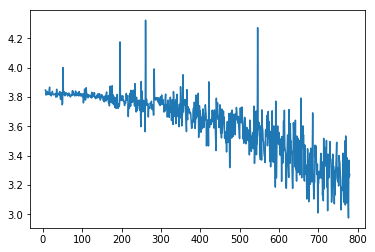

In [6]:
N=len(ArrI)
print(len(ArrI))
plt.plot(ArrI[5:N],ArrLoss[5:N])

## Save and load the Neural Network

In [ ]:
torch.save(model.state_dict(), "modelParameters/RGBImageModel.pth")

In [5]:
model.load_state_dict(torch.load("../../modelParameters/RGBImageModel.pth"))
model.eval()

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23120, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=46, bias=True)
)

In [6]:
def indexToLabel(labl):
    with open('labesIdx.csv') as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            if (labl==int(row[1])):
                Words = row[0].split("/")
                print(Words[-1])
            

## Test the Neural Network 

Only one result in order to test to random images-videos

Result of Neural Network -> Ground Truth

In [7]:
def testOneImage(mn_dataset_loader):
    for vid, labels in mn_dataset_loader:
        images = vid[:,1,:,:,:]


        images = np.einsum('klit->ktli',images) # This is really important because in order to work with 
            #The Conv2d I need to have (N,Channels,H,W) 
        images = torch.from_numpy(images) 
        images = images.type('torch.FloatTensor') # for converting to double tensor (cpu)

        #-----------------One of the Images--------------------
        imgShow = images[0,0,:,:]
        plt.imshow(imgShow,cmap='gray')
        #------------------------------------------------------

        output = model(images)
        k = output.detach().numpy()
        k.shape=(46,1)
        mk = k.tolist()

        
        print("Result of Neural Network -> Ground Truth")
        idx=np.argmax(k)
        indexToLabel(idx)
        print(torch.max(output,1))


        indexToLabel(labels[0])
        print(mk[labels[0]],labels[0])

        t = np.arange(46)
        mt = t.tolist()
        
        plt.figure()
        plt.plot(mt,mk)


        break


/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Result of Neural Network -> Ground Truth
Smoke_or_steam
(tensor([-0.7227], grad_fn=<MaxBackward0>), tensor([43]))
Smoke_or_steam
([-0.7227215766906738], tensor(43))


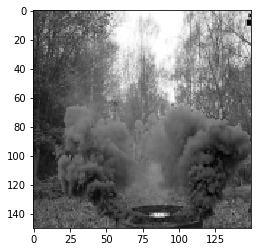

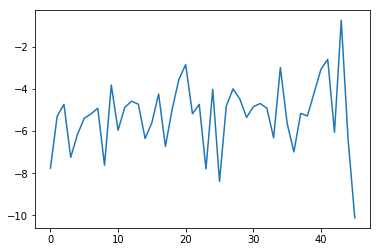

In [8]:
#----------------------------Data Loader------------------------
custom_mnist_from_csv = my_classes.customDatasetVideos('videoPath_labels.csv',frameStart=5,frames=5,startH=30,startW=30,heightVid=150,widthVid=150)


mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=1, shuffle=True, num_workers = 1)
#---------------------------------------------------------------

testOneImage(mn_dataset_loader)

## Persentage of correct Images on Test Set

In [9]:
def persentageCorrectPredictions(mn_dataset_loader):
    allResults=0
    correctResults=0

    for vid, labels in mn_dataset_loader:
        images = vid[:,1,:,:,:]


        images = np.einsum('klit->ktli',images) # This is really important because in order to work with 
            #The Conv2d I need to have (N,Channels,H,W) 
        images = torch.from_numpy(images) 
        images = images.type('torch.FloatTensor') # for converting to double tensor (cpu)





        output = model(images)
        k = output.detach().numpy()

        idx=np.argmax(k)

        allResults+=1

        if (idx == int(labels[0])):
            correctResults+=1

        pers = (float(correctResults)/float(allResults))*100

        print(allResults,correctResults,pers)

In [10]:
#----------------------------Data Loader------------------------
custom_mnist_from_csv = my_classes.customDatasetVideos('videoPath_LebelsTEST.csv',frameStart=5,frames=5,startH=30,startW=30,heightVid=150,widthVid=150)


mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=1, shuffle=True, num_workers = 7)
#---------------------------------------------------------------

persentageCorrectPredictions(mn_dataset_loader)

/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(1, 0, 0.0)
(2, 0, 0.0)
(3, 0, 0.0)
(4, 0, 0.0)
(5, 0, 0.0)
(6, 0, 0.0)
(7, 0, 0.0)
(8, 0, 0.0)
(9, 1, 11.11111111111111)
(10, 1, 10.0)
(11, 1, 9.090909090909092)
(12, 1, 8.333333333333332)
(13, 1, 7.6923076923076925)
(14, 1, 7.142857142857142)
(15, 1, 6.666666666666667)
(16, 1, 6.25)


No handlers could be found for logger "libav.swscaler"


(17, 1, 5.88235294117647)
(18, 1, 5.555555555555555)
(19, 1, 5.263157894736842)
(20, 1, 5.0)
(21, 1, 4.761904761904762)


No handlers could be found for logger "libav.swscaler"


(22, 1, 4.545454545454546)
(23, 1, 4.3478260869565215)
(24, 1, 4.166666666666666)
(25, 1, 4.0)
(26, 1, 3.8461538461538463)
(27, 1, 3.7037037037037033)
(28, 1, 3.571428571428571)
(29, 1, 3.4482758620689653)
(30, 1, 3.3333333333333335)
(31, 1, 3.225806451612903)
(32, 1, 3.125)
(33, 1, 3.0303030303030303)
(34, 1, 2.941176470588235)
(35, 1, 2.857142857142857)
(36, 1, 2.7777777777777777)


No handlers could be found for logger "libav.swscaler"


(37, 1, 2.7027027027027026)
(38, 2, 5.263157894736842)
(39, 2, 5.128205128205128)
(40, 2, 5.0)
(41, 2, 4.878048780487805)
(42, 2, 4.761904761904762)
(43, 2, 4.651162790697675)
(44, 2, 4.545454545454546)
(45, 2, 4.444444444444445)
(46, 2, 4.3478260869565215)
(47, 2, 4.25531914893617)
(48, 2, 4.166666666666666)
(49, 2, 4.081632653061225)
(50, 2, 4.0)
(51, 3, 5.88235294117647)
(52, 3, 5.769230769230769)


No handlers could be found for logger "libav.swscaler"


(53, 4, 7.547169811320755)
(54, 4, 7.4074074074074066)
(55, 4, 7.2727272727272725)
(56, 4, 7.142857142857142)
(57, 4, 7.017543859649122)
(58, 4, 6.896551724137931)
(59, 4, 6.779661016949152)
(60, 5, 8.333333333333332)
(61, 6, 9.836065573770492)
(62, 6, 9.67741935483871)
(63, 7, 11.11111111111111)
(64, 7, 10.9375)
(65, 8, 12.307692307692308)
(66, 8, 12.121212121212121)
(67, 8, 11.940298507462686)
(68, 8, 11.76470588235294)
(69, 8, 11.594202898550725)
(70, 8, 11.428571428571429)
(71, 9, 12.676056338028168)
(72, 9, 12.5)
(73, 9, 12.32876712328767)
(74, 9, 12.162162162162163)
(75, 9, 12.0)
(76, 10, 13.157894736842104)
(77, 10, 12.987012987012985)
(78, 10, 12.82051282051282)
(79, 10, 12.658227848101266)
(80, 10, 12.5)

No handlers could be found for logger "libav.swscaler"



(81, 10, 12.345679012345679)
(82, 10, 12.195121951219512)
(83, 10, 12.048192771084338)
(84, 10, 11.904761904761903)
(85, 10, 11.76470588235294)
(86, 10, 11.627906976744185)
(87, 10, 11.494252873563218)
(88, 10, 11.363636363636363)
(89, 10, 11.235955056179774)
(90, 10, 11.11111111111111)
(91, 10, 10.989010989010989)
(92, 10, 10.869565217391305)
(93, 10, 10.75268817204301)
(94, 10, 10.638297872340425)
(95, 10, 10.526315789473683)
(96, 10, 10.416666666666668)
(97, 10, 10.309278350515463)
(98, 10, 10.204081632653061)
(99, 10, 10.1010101010101)
(100, 10, 10.0)
(101, 10, 9.900990099009901)
(102, 10, 9.803921568627452)
(103, 10, 9.70873786407767)
(104, 10, 9.615384615384617)
(105, 10, 9.523809523809524)
(106, 10, 9.433962264150944)
(107, 10, 9.345794392523365)
(108, 11, 10.185185185185185)
(109, 11, 10.091743119266056)
(110, 11, 10.0)
(111, 11, 9.90990990990991)
(112, 11, 9.821428571428571)
(113, 11, 9.734513274336283)
(114, 11, 9.649122807017543)
(115, 11, 9.565217391304348)
(116, 11, 9.482

No handlers could be found for logger "libav.swscaler"


(140, 14, 10.0)
(141, 15, 10.638297872340425)
(142, 15, 10.56338028169014)
(143, 16, 11.188811188811188)
(144, 16, 11.11111111111111)
(145, 16, 11.03448275862069)
(146, 16, 10.95890410958904)
(147, 16, 10.884353741496598)
(148, 16, 10.81081081081081)
(149, 17, 11.409395973154362)
(150, 17, 11.333333333333332)
(151, 17, 11.258278145695364)
(152, 18, 11.842105263157894)
(153, 19, 12.418300653594772)
(154, 19, 12.337662337662337)
(155, 19, 12.258064516129032)
(156, 19, 12.179487179487179)
(157, 19, 12.101910828025478)
(158, 20, 12.658227848101266)
(159, 20, 12.578616352201259)
(160, 20, 12.5)
(161, 20, 12.422360248447205)
(162, 20, 12.345679012345679)
(163, 20, 12.269938650306749)
(164, 21, 12.804878048780488)
(165, 21, 12.727272727272727)
(166, 21, 12.650602409638553)
(167, 22, 13.17365269461078)
(168, 23, 13.690476190476192)
(169, 23, 13.609467455621301)
(170, 23, 13.529411764705882)
(171, 23, 13.450292397660817)
(172, 24, 13.953488372093023)
(173, 24, 13.872832369942195)
(174, 24, 13.7

Process Process-5:
Traceback (most recent call last):
Process Process-4:
Process Process-2:
Process Process-7:
Process Process-3:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process Process-8:
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/

KeyboardInterrupt: 

## Confusion Matrix

In [36]:
def convfusionMatrixF(mn_dataset_loader,dataChecked):
    
    
    widgets = ['Test: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #see docs for other options

    pbar = ProgressBar(widgets=widgets, maxval=dataChecked)
    pbar.start()

    LabelsCount=45
    
    ConfusionMatrix = np.zeros((LabelsCount,LabelsCount))
    i=0
    for vid, labels in mn_dataset_loader:
        
        images = vid[:,1,:,:,:]
        images = np.einsum('klit->ktli',images) # This is really important because in order to work with 
            #The Conv2d I need to have (N,Channels,H,W) 
        images = torch.from_numpy(images) 
        images = images.type('torch.FloatTensor') # for converting to double tensor (cpu)


        
        output = model(images)
        k = output.detach().numpy()
        idx=np.argmax(k)
        actualValue=int(labels[0])

        
        ConfusionMatrix[idx,actualValue]=ConfusionMatrix[idx,actualValue]+1

    
        #---------------Next Interation--------------------
        i+=1  
        if (i>dataChecked):
            break   
        pbar.update(i)
        #--------------------------------------------------

        
    #----------------Normalize the Confusion Matrix-----------------
#     sumRow = ConfusionMatrix.sum(axis=1)
#     sumRow = sumRow.reshape(LabelsCount,1)    
#     ConfusionMatrix = np.divide(ConfusionMatrix,sumRow)
    #---------------------------------------------------------------
    
        
    return ConfusionMatrix

    


No handlers could be found for logger "libav.swscaler"TA:  --:--:--   0.00  B/s
No handlers could be found for logger "libav.swscaler"
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
No handlers could be found for logger "libav.swscaler"
No handlers could be found for logger "libav.swscaler"ETA:  0:01:18  12.62  B/s
No handlers could be found for logger "libav.swscaler"ETA:  0:00:48  19.73  B/s
No handlers could be found for logger "libav.swscaler"ETA:  0:00:39  22.02  B/s
No handlers could be found for logger "libav.swscaler"ETA:  0:00:36  22.80  B/s
No handlers could be found for logger "libav.swscaler"ETA:  0:00:35  22.78  B/s
No handlers could be found for logger "libav.swscaler"ETA:  0:00:33  23.57  B/s
No handlers could be found for logger "libav.swscaler"ETA:  0:00:04  25.41  B/s


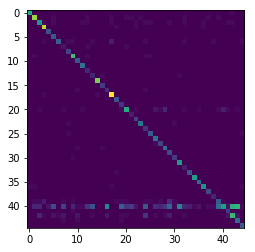

In [37]:
#----------------------------Data Loader------------------------
custom_mnist_from_csv = my_classes.customDatasetVideos('videoPath_labels.csv',frameStart=5,frames=5,startH=30,startW=30,heightVid=150,widthVid=150)

mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=1, shuffle=True, num_workers = 10)
#---------------------------------------------------------------

ConfusionMatrix=convfusionMatrixF(mn_dataset_loader,1000)

plt.imshow(ConfusionMatrix)

In [35]:
print(ConfusionMatrix[24,:])

for i in range(45):
    print(ConfusionMatrix[i,i])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0.96
0.787234042553
0.555555555556
1.0
0.916666666667
1.0
0.642857142857
0.833333333333
1.0
0.828571428571
1.0
1.0
1.0
0.846153846154
1.0
1.0
0.818181818182
0.948717948718
1.0
1.0
0.651162790698
1.0
1.0
1.0
1.0
0.666666666667
0.916666666667
0.666666666667
0.9
1.0
1.0
0.833333333333
1.0
1.0
0.92
0.9375
0.851851851852
1.0
1.0
0.511627906977
0.112033195021
0.923076923077
0.428571428571
0.7
1.0


## Progress Bar

In [15]:
from progressbar import *               # just a simple progress bar


widgets = ['Test: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #see docs for other options

pbar = ProgressBar(widgets=widgets, maxval=50)
pbar.start()

for i in range(50):
    # here do something long at each iteration
    pbar.update(i) #this adds a little symbol at each iteration
    time.sleep(0.05)
pbar.finish()

Test: 100% [0000000000000000000000000000000000000000] Time: 0:00:02  19.86  B/s
